In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import yfinance as yf
from statsmodels.sandbox.tools import tools_pca
from sklearn.decomposition import PCA

In [2]:
def compareModelGraph(model1, model2):
    plt.figure(figsize=(15, 10))
    plt.rcParams["font.size"] = "20"
    plt.plot(range(len(model1.yTest)), model1.yTest, label="real")
    plt.plot(range(len(model1.yPred)), model1.yPred, label="model1")
    plt.plot(range(len(model2.yPred)), model2.yPred, label="model2")
    plt.ylabel("y", fontsize=15)
    plt.xlabel("x", fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()
    return

In [159]:
class MLP:
    def __init__(self, xyTrainTest, batchNorm=None, dropout=None, dropoutProb=0.2, layerN=3, actFunc="relu", nn=64, alpha=0, lr=0.01):
        actFuncDict = {"relu": tf.keras.layers.ReLU(negative_slope=alpha), "tanh": tf.keras.layers.Activation('tanh')}
        assert isinstance(xyTrainTest, (list, tuple)) and (len(xyTrainTest) == 4)
        assert isinstance(actFunc, str) and actFunc.lower() in actFuncDict.keys()
        assert (batchNorm is None) or isinstance(batchNorm, (int, list))
        assert (dropout is None) or isinstance(dropout, (int, list))
        assert layerN > 0
        self.xTrain, self.yTrain, self.xTest, self.yTest = xyTrainTest
        self.trainLen = len(self.xTrain)
        self.layerN = layerN
        self.batchNorm = batchNorm
        self.dropout = dropout
        self.dropoutProb = dropoutProb
        self.actFunc = actFuncDict.get(actFunc.lower())
        self.nn = nn
        self.lr = lr
        self.unNorm = False
        return
    
    def buildModel(self):
        layerN = self.layerN
        batchNorm = self.batchNorm
        dropout = self.dropout
        model = tf.keras.models.Sequential()
        for i in range(1,(layerN+1)):
            model.add(tf.keras.layers.Dense(self.nn, activation=self.actFunc))
            if batchNorm and ((i == batchNorm) or (i in batchNorm)):
                model.add(tf.keras.layers.BatchNormalization())
            if dropout and ((i == dropout) or (i in dropout)):
                model.add(tf.keras.layers.Dropout(self.dropoutProb))
        model.add(tf.keras.layers.Dense(1, activation=self.actFunc))
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss="mse",  metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        return model

    def train(self, bs=32, ntry=10):
        validLen = math.ceil(self.trainLen * 0.2)
        model = self.buildModel()
        model.fit(self.xTrain, self.yTrain    , batch_size=bs, epochs=100, shuffle=True, verbose=0)
        self.bestModel = model
        bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        
        for i in range(ntry):
            model = self.buildModel()
            model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=100, shuffle=True, verbose=0)
            if model.evaluate(self.xTrain, self.yTrain) < bestLoss:
                self.bestModel = model
                bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        return bestLoss

    def predict(self):
        self.yPred = self.bestModel.predict(self.xTest)
        return
    
    def RMSE(self, l=None, h=None):
        if (not self.unNorm) and (l is not None) and (h is not None):
            self.yTest = self.yTest * (h-l) + l
            self.yPred = self.yPred * (h-l) + l
            self.unNorm = True
        self.rmse = np.sqrt(np.mean(np.square(self.yTest-self.yPred)))
        return self.rmse
    
    def genGraph(self, l=None, h=None):
        testLen = len(self.yTest)
        self.predict()
        yTest = self.yTest
        yPred = self.yPred
        if (not self.unNorm) and (l is not None) and (h is not None):
            yTest = yTest * (h-l) + l
            yPred = yPred * (h-l) + l
            self.yTest = yTest
            self.yPred = yPred
            self.unNorm = True
        plt.figure(figsize=(15, 10))
        plt.rcParams["font.size"] = "20"
        plt.plot(range(testLen), yTest, label="true")
        plt.plot(range(testLen), yPred, label="predict")
#         plt.title(f"{} {}")
        plt.ylabel("y", fontsize=15)
        plt.xlabel("x", fontsize=15)
        plt.legend(loc="lower right", fontsize=15)
        plt.show()
        return

In [172]:
class DataProcessor:
    def __init__(self):
        return
    
    def generate_train_test(self, df, seqLen, covid=True, split=0.8, trainLen=None, norm=False, pca=None, logRet=False):
        if not covid:
            df = df.loc[df.index < "2020-03-01"] 
        if logRet:
            retDf = df.iloc[:,[0]].copy()
            retDf = np.log(retDf/retDf.shift())
            df = df.join(retDf, rsuffix="_").fillna(0)
        if trainLen is None:
            trainLen = math.ceil(len(df) * split)
        train = df.iloc[:trainLen]
        test = df.iloc[trainLen:]
        if pca is not None:
            pcaDfTrain = train.loc[:,pca].values
            pcaDfTest = test.loc[:,pca].values
            train.drop(pca, axis=1, inplace=True)
            test.drop(pca, axis=1, inplace=True)
            pcaObj = PCA(0.9)
            pcaObj.fit(pcaDfTrain)
            train = train.join(pd.DataFrame(pcaObj.transform(pcaDfTrain), index=train.index))
            test = test.join(pd.DataFrame(pcaObj.transform(pcaDfTest), index=test.index))
        print(train)
        if norm:
            l = train.min()
            h = train.max()
            self.l = l.iloc[0]
            self.h = h.iloc[0]
            train = (train - l)/(h-l)
            test = (test - l)/(h-l)
        targetTrain = train.iloc[:,0]
        targetTest = test.iloc[:,0]
        facTrain = train.iloc[:,1:]
        facTest = test.iloc[:,1:]
        
        xTrainL, yTrainL, xTestL, yTestL = [], [], [], []
        for i in range(len(train) - seqLen):
            xTrainL.append(np.hstack([targetTrain.iloc[i:(i+seqLen)].values.flatten("F"), facTrain.iloc[(i+seqLen-2):(i+seqLen)].values.flatten("F")]))
            yTrainL.append(targetTrain.iloc[(i+seqLen)].flatten())
        for i in range(len(test) - seqLen):
            xTestL.append(np.hstack([targetTest.iloc[i:(i+seqLen)].values.flatten("F"), facTest.iloc[(i+seqLen-2):(i+seqLen)].values.flatten("F")]))
            yTestL.append(targetTest.iloc[(i+seqLen)].flatten())
        self.trainLen = trainLen
        self.testStartDate = df.index[trainLen]
        return [np.array(xTrainL), np.array(yTrainL), np.array(xTestL), np.array(yTestL)]

In [155]:
tf.random.set_seed(4012)

In [4]:
start = "2012-03-01"
end = "2022-03-01"
oilPrice = yf.download("CL=F", start=start, end=end).loc[:,["Close"]]

[*********************100%***********************]  1 of 1 completed


In [18]:
facDict = {"Close": ["OXY", "DX-Y.NYB"], "Volume": ["CL=F"]}
factors = list(set([i for arr in facDict.values() for i in arr]))
mulIdx = pd.MultiIndex.from_tuples([(key, val) for key in facDict.keys() for val in facDict.get(key)])
if len(factors) == 1:
    mulIdx = list(facDict.keys())
facDf = yf.download(factors, start=start, end=end).loc[:, mulIdx]
if facDf.columns.nlevels > 1:
    facDf.columns = [" ".join(pair[::-1]) for pair in facDf.columns]

[*********************100%***********************]  3 of 3 completed


In [20]:
tmpRatesDf = pd.read_csv("./dataset/rates.csv", index_col=0, parse_dates=True)
ratesDf = pd.DataFrame(index=oilPrice.index).join(tmpRatesDf).ffill()
ratesPeriod = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10]
contRatesDf = ratesDf.copy()
for i in range(len(ratesDf.columns)):
    if ratesPeriod[i] < 1:
        contRatesDf.iloc[:,i] = np.log(ratesDf.iloc[:,i]*ratesPeriod[i] + 1)/ratesPeriod[i]
    else:
        contRatesDf.iloc[:,i] = np.log((ratesDf.iloc[:,i] + 1) ** ratesPeriod[i])/ratesPeriod[i]
fwdRatesDf = contRatesDf.copy()
for i in range(1,len(ratesPeriod)):
    fwdRatesDf.iloc[:,i] = (contRatesDf.iloc[:,i]*ratesPeriod[i] - contRatesDf.iloc[:,(i-1)]*ratesPeriod[i-1]) / (ratesPeriod[i] - ratesPeriod[i-1])

In [69]:
oilPrice
oilRates = oilPrice.join(fwdRatesDf)

In [141]:
dataP = DataProcessor()
modelP = MLP(dataP.generate_train_test(oilPrice, 5, covid=False, norm=True), alpha=0)
modelP.train()

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-24   51.430000
2020-02-25   49.900002
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998

[2011 rows x 1 columns]
Close    26.209999
dtype: float64
Close    110.529999
dtype: float64
51/51 [==============================] - 0s 848us/step - loss: 7.2304e-04 - root_mean_squared_error: 0.0269


[0.0004911344149149954, 0.02216155268251896]

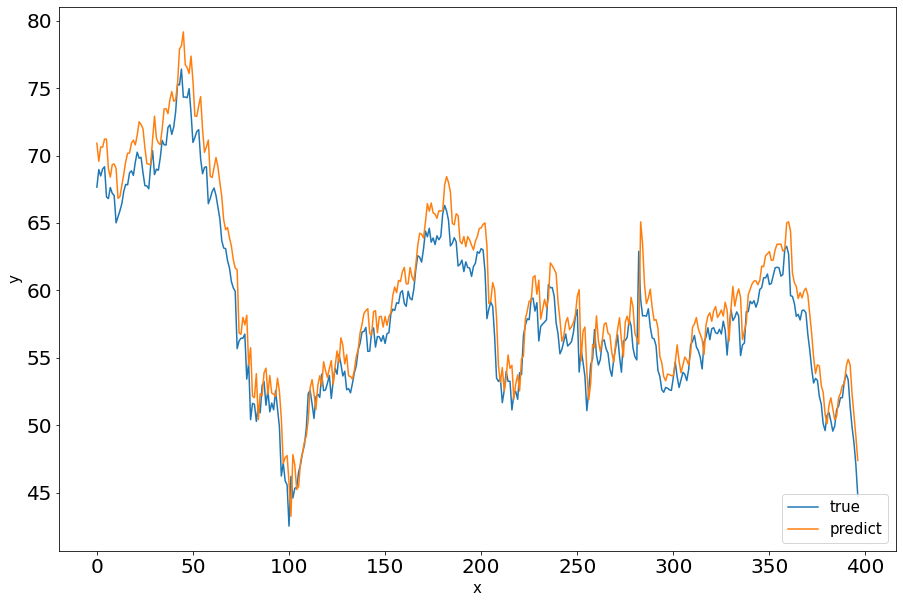

2.038858459095986

In [124]:
modelP.genGraph(l=dataP.l, h=dataP.h)
modelP.RMSE()

In [160]:
dataP1 = DataProcessor()
modelP1 = MLP(dataP1.generate_train_test(oilPrice, 5, covid=False, norm=True), batchNorm=[1,2,3], dropout=[1,2,3], alpha=0)
modelP1.train()

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2018-07-18   68.760002
2018-07-19   69.459999
2018-07-20   70.459999
2018-07-23   67.889999
2018-07-24   68.519997

[1609 rows x 1 columns]
51/51 [==============================] - 0s 1ms/step - loss: 0.0015 - root_mean_squared_error: 0.0381


[0.000232447317102924, 0.015246222727000713]

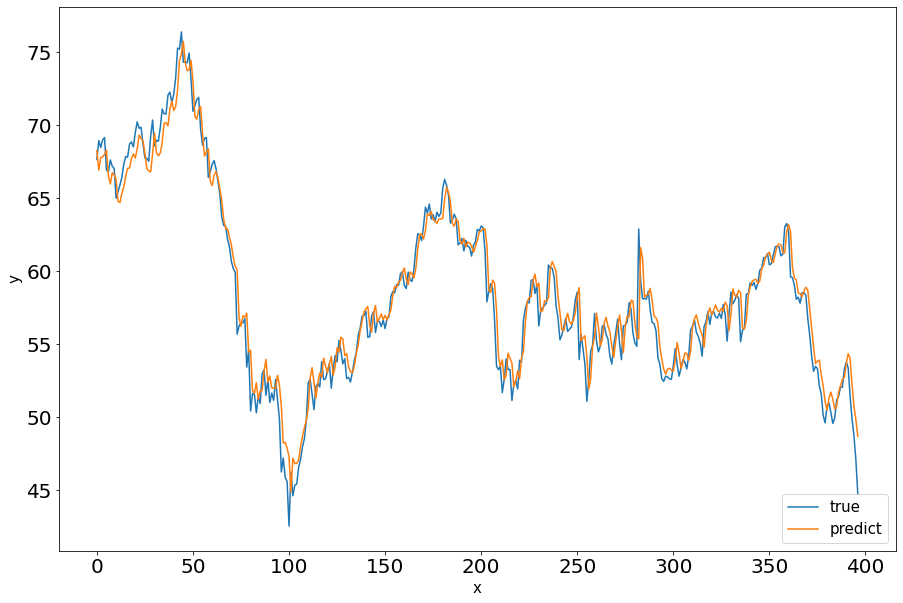

1.3528212697072275

In [161]:
modelP1.genGraph(l=dataP1.l, h=dataP1.h)
modelP1.RMSE()

In [176]:
dataPR = DataProcessor()
modelPR = MLP(dataPR.generate_train_test(oilRates, 5, covid=False, norm=True, pca=oilRates.columns[1:]), alpha=0)
modelPR.train()

In [ ]:
modelPR.genGraph(l=dataPR.l, h=dataPR.h)
modelPR.RMSE()

In [174]:
dataPR1 = DataProcessor()
modelPR1 = MLP(dataPR1.generate_train_test(oilRates, 5, covid=False, norm=True, pca=oilRates.columns[1:]), batchNorm=[1,2,3], alpha=0)
modelPR1.train()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


                 Close         0         1
Date                                      
2012-02-29  107.070000 -0.656685  0.317128
2012-03-01  108.839996 -0.661008  0.284948
2012-03-02  106.699997 -0.689269  0.326575
2012-03-05  106.720001 -0.656589  0.314774
2012-03-06  104.699997 -0.679028  0.366178
...                ...       ...       ...
2018-07-18   68.760002  2.265399 -0.038445
2018-07-19   69.459999  2.255852 -0.021582
2018-07-20   70.459999  2.246711 -0.043765
2018-07-23   67.889999  2.267881 -0.075026
2018-07-24   68.519997  2.287274 -0.077318

[1609 rows x 3 columns]
51/51 [==============================] - 0s 977us/step - loss: 3.8330e-04 - root_mean_squared_error: 0.0196


[0.00030964481993578374, 0.01759672723710537]

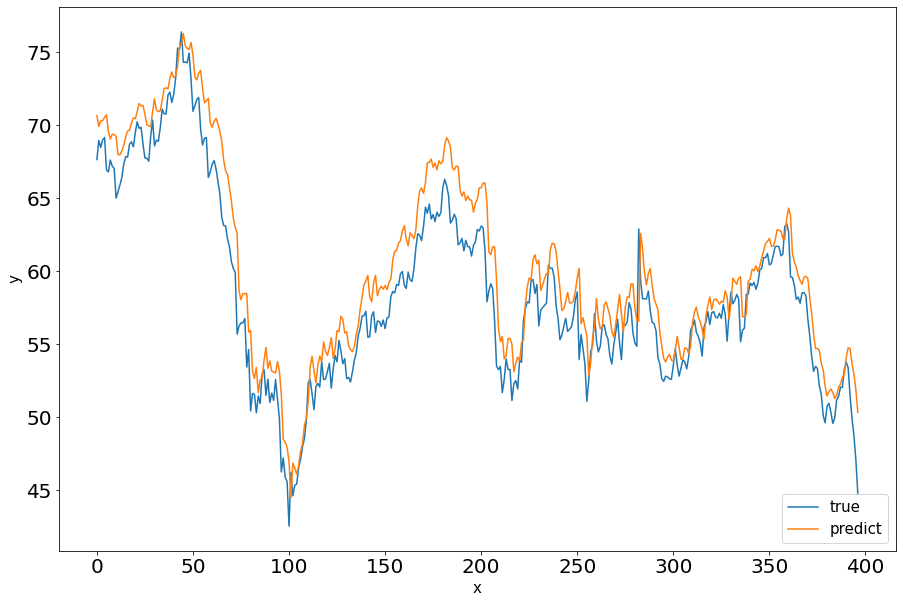

2.4153982371213947

In [175]:
modelPR1.genGraph(l=dataPR1.l, h=dataPR1.h)
modelPR1.RMSE()

In [729]:
# tmpRatesDf = pd.read_csv("./dataset/FED-SVENY.csv", index_col=0, parse_dates=True)
# ratesDf = pd.DataFrame(index=data.df.index).join(tmpRatesDf).ffill() / 100

In [730]:
# fwdRatesDf = ratesDf.copy()
# for i in range(1,len(ratesDf.columns)):
#     fwdRatesDf.iloc[:,i] = ratesDf.iloc[:,i]*(i+1) - ratesDf.iloc[:,(i-1)] * i

In [447]:
modelPV = MLP(dataVol.generate_train_test(dataVol.df, 5, covid=False, norm=True), alpha=0)
modelPV.train()

Close        26.209999
Volume    48516.000000
dtype: float64
Close     1.105300e+02
Volume    1.311000e+06
dtype: float64
11/11 [==============================] - 0s 1ms/step - loss: 3.5810e-04 - root_mean_squared_error: 0.0189


[0.00035809926339425147, 0.01892351172864437]

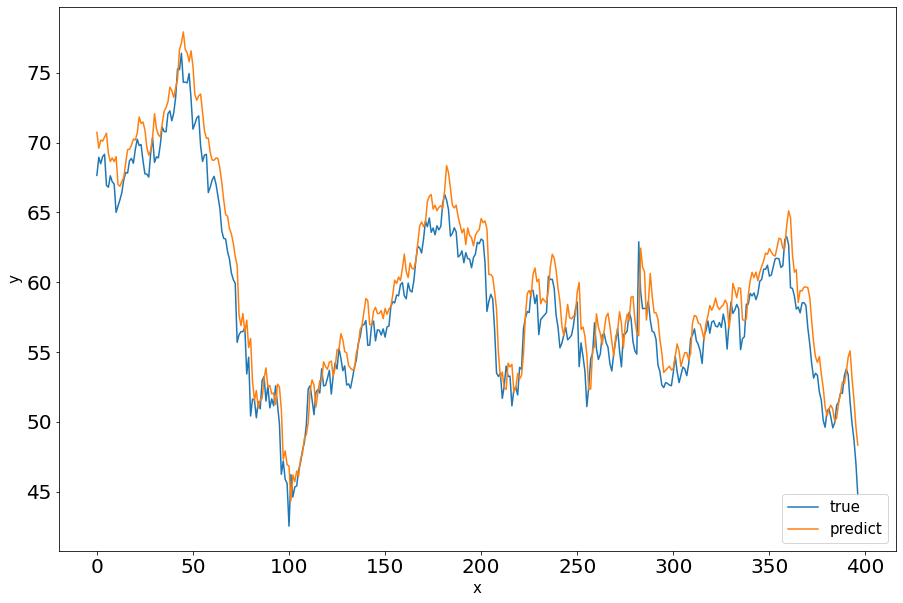

In [448]:
modelPV.genGraph(l=dataVol.l, h=dataVol.h)

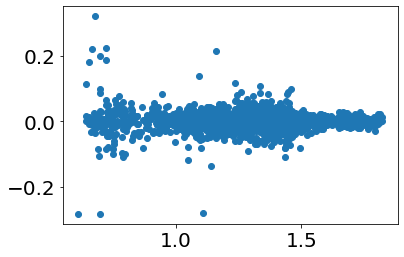

In [137]:
plt.scatter(fwdRatesDf.iloc[:,7], logretDf)
plt.show()

In [129]:
logretDf = np.log(oilPrice/oilPrice.shift()).fillna(0)

In [130]:
logretDf

,Close
Date,
2012-02-29,0.000000
2012-03-01,0.016396
2012-03-02,-0.019858
2012-03-05,0.000187
2012-03-06,-0.019110
...,...
2022-02-22,0.013957
2022-02-23,-0.002711
2022-02-24,0.007679


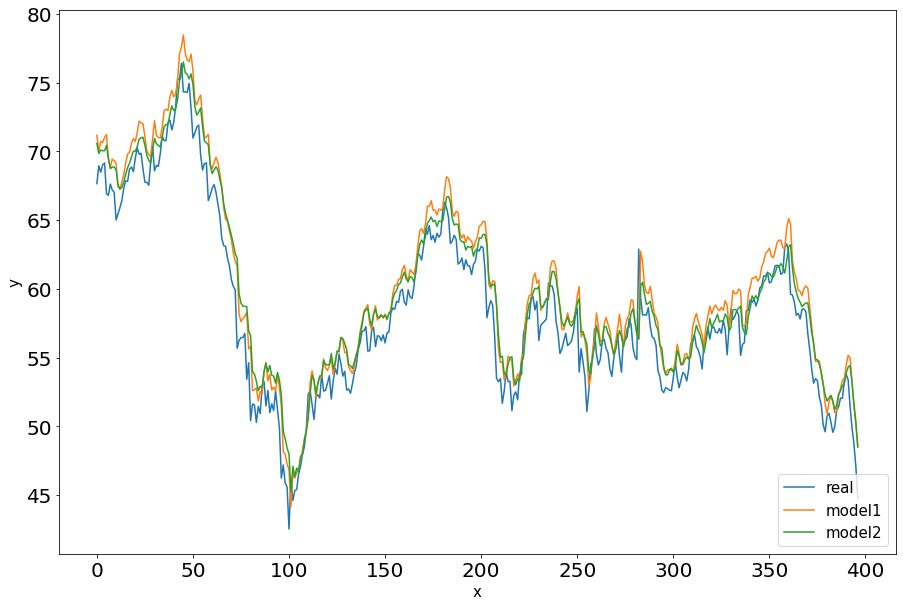

In [151]:
compareModelGraph(modelP, modelPR)

In [171]:
oilRates

,Close,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10
Date,,,,,,,,,,
2012-02-29,107.070000,0.079735,0.078949,0.172689,0.205079,0.359214,0.548295,1.028334,1.484681,1.606726
2012-03-01,108.839996,0.069797,0.083917,0.172689,0.205079,0.359214,0.548295,1.054930,1.530551,1.613880
2012-03-02,106.699997,0.059850,0.074167,0.163681,0.197470,0.336716,0.537049,1.009029,1.510438,1.627677
2012-03-05,106.720001,0.069797,0.083917,0.191424,0.178690,0.383051,0.532969,1.028334,1.499295,1.619281
2012-03-06,104.699997,0.059850,0.088891,0.172689,0.188058,0.367725,0.484688,1.006082,1.479664,1.623662
...,...,...,...,...,...,...,...,...,...,...
2022-02-22,92.349998,0.029963,0.515831,0.890743,0.927145,1.105287,1.143859,1.106361,1.144211,1.086360
2022-02-23,92.099998,0.019983,0.479488,0.932923,0.910595,1.125471,1.171774,1.119465,1.168590,1.103090
2022-02-24,92.809998,0.049896,0.436818,0.817806,0.901911,1.131960,1.148577,1.103058,1.164923,1.101009
